In [2]:
!nvidia-smi

Wed Feb 28 18:29:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8               7W /  95W |    102MiB /  4096MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [58]:
import warnings
warnings.filterwarnings(action='ignore',category=FutureWarning)


In [163]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Concatenate,Embedding,LayerNormalization,Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
tf.keras.backend.set_floatx('float32')

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [164]:
# DATA_PATH='hindi_english_parallel - Copy.csv'
DATA_PATH='hindi_english_parallel - Copy.csv'
CHECKPOINT_PATH = 'C:/Users/Prasanna/.vscode/Translator/check_temp'
os.mkdir(CHECKPOINT_PATH)

SAMPLES=30000
MAX_WORDS=20
VOCAB=10000
BATCH_SIZE=64

In [166]:
train=pd.read_csv(DATA_PATH)
# train=train.drop("source",axis=1)
train.head()

,english,hindi
0,Give your application an accessibility workout,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें
1,Accerciser Accessibility Explorer,एक्सेर्साइसर पहुंचनीयता अन्वेषक
2,The default plugin layout for the bottom panel,निचले पटल के लिए डिफोल्ट प्लग-इन खाका
3,The default plugin layout for the top panel,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका
4,A list of plugins that are disabled by default,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से निष्क्रिय किया गया है


In [167]:
train=train.sample(SAMPLES)

In [168]:
train['english'] = train['english'].apply(lambda x: '<start> '+str(x)+' <end>')
train['hindi'] = train['hindi'].apply(lambda x: '<start> '+str(x)+' <end>')
train.head()

,english,hindi
703110,<start> Failure during recursive unset of “% s”:% s“% s” <end>,<start> के एकांतर अनसेट में विफलः% s <end>
955461,<start> We can get ActiveLight at SourceForge. net with free downloads from the largest Open Source applications and software directory. <end>,<start> हमें सक्रिय प्रकाश सोर्सफोर्ज. नेट पर व्यापक मुक्त स्रोत अनुप्रयोग तथा सॉफ्टवेयर निदेशिका से मुफ्त डाउनलोड मिल सकता है। <end>
527383,"<start> It 's this, just like this. <end>",<start> और यह बस इसी तरह है। <end>
858408,<start> Haiti <end>,<start> हैटी गणतंत्र <end>
212392,<start> nan <end>,<start> nan <end>


In [170]:
tokenizerE = Tokenizer(num_words=VOCAB, oov_token='<OOV>', lower=True, filters='#$!"%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

tokenizerE.fit_on_texts(train['english'])

eng_inp = tokenizerE.texts_to_sequences(train['english'])

eng_inp = pad_sequences(eng_inp,maxlen=MAX_WORDS,truncating='post',padding='post',dtype='int64')

In [171]:
tokenizerH = Tokenizer(num_words=VOCAB,oov_token='<OOV>',lower=True,filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

tokenizerH.fit_on_texts(train['hindi'])

hin_inp=tokenizerH.texts_to_sequences(train['hindi'])

hin_inp=pad_sequences(hin_inp,maxlen=MAX_WORDS,truncating='post',padding='post',dtype='int64')

In [172]:
rev_hin_dict = dict(map(reversed, tokenizerH.word_index.items()))

In [173]:
dataset = tf.data.Dataset.from_tensor_slices((eng_inp,hin_inp)).shuffle(SAMPLES).batch(BATCH_SIZE,drop_remainder=True)

In [174]:
def pos_enc(posi,dim):
    mat=1 / 10000 ** ( 2*(np.expand_dims(np.arange(0,dim),1)//2) / np.float32(dim) )    
    pos=np.expand_dims(np.arange(0,posi),1)   
    mat=np.reshape(mat,(1,dim))   
    mul=pos*mat
    mul[:, 0::2]=np.sin(mul[:, 0::2])
    mul[:, 1::2]=np.cos(mul[:, 1::2])
    mul=np.reshape(mul,(1,posi,dim))  
    return tf.cast(mul,dtype=tf.float32)

In [175]:
def padding_mask(ans):
    ans=tf.cast(tf.math.equal(ans,0),tf.float32)
    ans=ans[:,tf.newaxis,tf.newaxis,:]
    return ans

In [176]:
def look_ahead(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [177]:
def attention(q,k,v,mask):
    matmul1=tf.matmul(q,k,transpose_b=True)
    scale = matmul1 / tf.math.sqrt( tf.cast(tf.shape(k)[-1],dtype=tf.float32))
    if mask is not None:
        scale+=mask*(-1e9)
    attn_wt = tf.nn.softmax(scale,axis=-1)
    matmul2 = tf.matmul(attn_wt,v)
    return matmul2,attn_wt

In [178]:
class multi_head_attention(tf.keras.layers.Layer):
    def __init__(self,num_heads,d):       
        super(multi_head_attention,self).__init__()       
        self.d=d
        self.num_heads=num_heads
        assert d%self.num_heads == 0
        self.depth=d//self.num_heads       
        self.denseQ=Dense(self.d)
        self.denseK=Dense(self.d)
        self.denseV=Dense(self.d)
        self.denseOUT=Dense(self.d)
    
    def split_heads(self,x,batch):        
        x=tf.reshape(x, (batch, -1, self.num_heads, self.depth))
        return tf.transpose(x,perm=[0,2,1,3])
    
    def __call__(self,q,k,v,mask):
        batch=tf.shape(q)[0]
        q=self.denseQ(q)
        k=self.denseK(k)
        v=self.denseV(v)       
        q=self.split_heads(q,batch)
        k=self.split_heads(k,batch)
        v=self.split_heads(v,batch)
        out1attn,out2attnwt=attention(q,k,v,mask)
        out1attn=tf.transpose(out1attn,perm=[0,2,1,3])
        out1attn2=tf.reshape(out1attn,(batch,-1,self.d))
        out1attn3=self.denseOUT(out1attn2)
        return out1attn3,out2attnwt

In [179]:
def feed_forward(d1,d2):
    return Sequential([
        Dense(d1,activation='relu'),
        Dense(d2)
    ])

In [180]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d,D):
        super(EncoderLayer,self).__init__()        
        self.mha=multi_head_attention(num_heads,d)
        self.ffn=feed_forward(D,d)       
        self.norm1=LayerNormalization(epsilon=1e-6)
        self.norm2=LayerNormalization(epsilon=1e-6)        
        self.drop1=Dropout(0.1)
        self.drop2=Dropout(0.1)
    
    def __call__(self,x,training,mask):
        mha,_=self.mha(x,x,x,mask)
        mha=self.drop1(mha,training=training)       
        tmp1=self.norm1(x+mha)              
        tmp2=self.ffn(tmp1)
        tmp2=self.drop2(tmp2,training=training)  
        tmp3=self.norm2(tmp1+tmp2)
        return tmp3

In [181]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d,D):
        super(DecoderLayer,self).__init__()     
        self.mha1=multi_head_attention(num_heads,d)
        self.mha2=multi_head_attention(num_heads,d)
        self.ffn=feed_forward(D,d)      
        self.norm1=LayerNormalization(epsilon=1e-6)
        self.norm2=LayerNormalization(epsilon=1e-6)        
        self.norm3=LayerNormalization(epsilon=1e-6)       
        self.drop1=Dropout(0.1)
        self.drop2=Dropout(0.1)
        self.drop3=Dropout(0.1)
        
    def __call__(self, x, encout, training, look_ahead, padding_mask):
        mha1,attnwt1=self.mha1(x,x,x,look_ahead)
        mha1=self.drop1(mha1,training=training)        
        tmp1=self.norm1(x+mha1)       
        mha2,attnwt2=self.mha2(tmp1,encout,encout,padding_mask)
        mha2=self.drop2(mha2,training=training)        
        tmp2=self.norm2(tmp1+mha2)    
        tmp3=self.ffn(tmp2)
        tmp3=self.drop3(tmp3,training=training)
        tmp4=self.norm3(tmp2+tmp3)
        return tmp4,attnwt1,attnwt2

In [182]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,vocab,d,maxposencsize,num_heads,D,num_layers):
        super(Encoder,self).__init__()
        self.d=d
        self.num_layers=num_layers          
        self.emb=Embedding(vocab,d)
        self.posenc=pos_enc(maxposencsize,self.d)
        self.enclayers=[EncoderLayer(num_heads,d,D) for _ in range(num_layers)]
        self.drop=Dropout(0.1)
      
    def __call__(self,x,training,mask):
        tmp=tf.shape(x)[1]
        x=self.emb(x)   
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))    
        x+=self.posenc[:,:tmp,:]     
        x=self.drop(x,training=training)
        for i in range(self.num_layers):
            x=self.enclayers[i](x,training,mask)
        return x

In [183]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,vocab,d,maxposencsize,num_heads,D,num_layers):
        super(Decoder,self).__init__()
        self.d=d
        self.num_layers=num_layers              
        self.emb=Embedding(vocab,d)    
        self.posenc=pos_enc(maxposencsize,d)
        self.declayers=[DecoderLayer(num_heads,d,D) for _ in range(num_layers)]
        self.drop=Dropout(0.1)
       
    def __call__(self,x,encout,training,look_ahead, padding_mask):
        tmp=tf.shape(x)[1]
        attnout={}
        x=self.emb(x)    
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))     
        x+=self.posenc[:,:tmp,:]       
        x=self.drop(x,training=training)
        for i in range(self.num_layers):
            x,attnwt1,attnwt2=self.declayers[i](x,encout,training,look_ahead, padding_mask)
            attnout['decoder_layer{}_block1'.format(i+1)] = attnwt1
            attnout['decoder_layer{}_block2'.format(i+1)] = attnwt2
        return x,attnout

In [184]:
class Transformer(tf.keras.Model):
    def __init__(self,vocab,d,maxposencsize,num_heads,D,num_layers):
        super(Transformer,self).__init__()
        self.encoder=Encoder(vocab,d,maxposencsize,num_heads,D,num_layers)
        self.decoder=Decoder(vocab,d,maxposencsize,num_heads,D,num_layers)
        self.dense=Dense(vocab)
        
    def __call__(self,x,y,training,mask,look_ahead, padding_mask):
        encoder_call=self.encoder(x,training,mask)
        decoder_call,attnwt_call=self.decoder(y,encoder_call,training,look_ahead, padding_mask)
        decoder_call=self.dense(decoder_call)
        return decoder_call,attnwt_call

In [185]:
d=128
D=512
num_heads=8
num_layers=4
maxposencsize=VOCAB
EPOCH=30

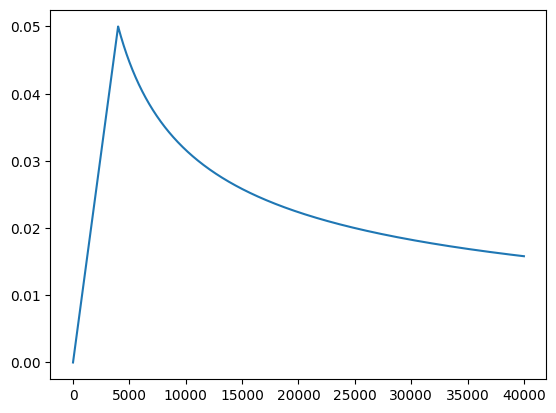

In [186]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ensure step is a float
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        lrate = (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

        return lrate

d = 0.1
lrate = CustomSchedule(d)

plt.plot(lrate(tf.range(40000, dtype=tf.float32)))
plt.show()


In [187]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [188]:
def create_masks(x,y):
    tmp1=padding_mask(x)
    tmp2=padding_mask(x)    
    tmp3=look_ahead(tf.shape(y)[1])
    tmp4=padding_mask(y)
    tmp5=tf.maximum(tmp3,tmp4)     
    return tmp1,tmp5,tmp2

In [189]:
VOCAB = int(10000.0)  # Cast to integer
d = int(512.0)  # Cast to integer
max_pos_enc_size = int(1000.0)  # Cast to integer
num_heads = int(8.0)  # Cast to integer
D = int(2048.0)  # Cast to integer
num_layers = int(6.0)  # Cast to integer

transformer = Transformer(VOCAB,d,maxposencsize,num_heads,D,num_layers)

In [190]:
# Replace your existing optimizer definition with the legacy optimizer
optimizer = tf.keras.optimizers.legacy.Adam(lrate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


In [191]:
checkpoint_path = CHECKPOINT_PATH
ckpt = tf.train.Checkpoint(transformer=transformer,optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [192]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def training(x,y):
    y_inp=y[:,:-1]
    y_real=y[:,1:]   
    mask,look_ahead, padding_mask=create_masks(x,y_inp)                                            
    with tf.GradientTape() as tape:         
        pred,_=transformer(x, y_inp, True, mask, look_ahead, padding_mask)
        loss=loss_function(y_real,pred)              
    variables=transformer.trainable_variables
    gradients=tape.gradient(loss, variables) 
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(loss)

In [193]:
import time
for epoch in range(EPOCH): 
    start_time=time.time()     
    train_loss.reset_states()   
    print("Starting epoch {}".format(epoch+1))       
    for x_batch,y_batch in dataset:
        training(x_batch, y_batch)       
    end_time=time.time()
    print('loss = {:.4f}\ttime taken = {:.2f} secs'.format(train_loss.result(),end_time-start_time))      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()

Starting epoch 1
loss = 6.1696	time taken = 708.12 secs
Starting epoch 2
loss = 5.9304	time taken = 740.30 secs
Starting epoch 3
loss = 5.8819	time taken = 718.31 secs
Starting epoch 4
loss = 5.8883	time taken = 723.69 secs
Starting epoch 5
loss = 5.8729	time taken = 720.80 secs
Starting epoch 6
loss = 5.8877	time taken = 706.73 secs
Starting epoch 7
loss = 5.9669	time taken = 706.44 secs
Starting epoch 8
loss = 6.0255	time taken = 702.44 secs
Starting epoch 9
loss = 6.0716	time taken = 708.16 secs
Starting epoch 10


In [ ]:
def evaluate(text,plot=False):   
 
    text=tokenizerE.texts_to_sequences(text)
    text=np.array(text).astype('int64')
    text=pad_sequences(text,maxlen=MAX_WORDS,truncating='post',padding='post',dtype='int64')

    decinp=[tokenizerH.word_index['<start>']]
    decinp=tf.expand_dims(decinp,0)
    for i in range (MAX_WORDS):
        m1,m2,m3=create_masks(text,decinp)
        p,a=transformer(text,decinp,False,m1,m2,m3)
        p=p[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(p, axis=-1), tf.int32)
        decinp=tf.concat([decinp,predicted_id],axis=-1)

    ans=sentence(decinp.numpy()[0])
     
    if plot==True:
        att=[a['decoder_layer4_block2'].numpy()[0,i] for i in range(num_heads)]
        for j in range (num_heads):
            plt.matshow(att[j])
            plt.show()
            
    print("Translated Sentence: ",ans)


In [ ]:
def sentence(x):
    ans=''
    for w in x:
        ans+=rev_hin_dict[w]+' '
        if w == tokenizerH.word_index['<end>']:
            return ans
    return ans

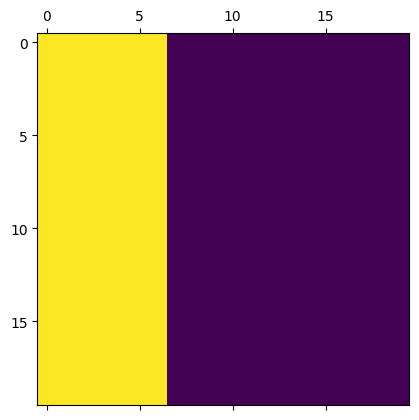

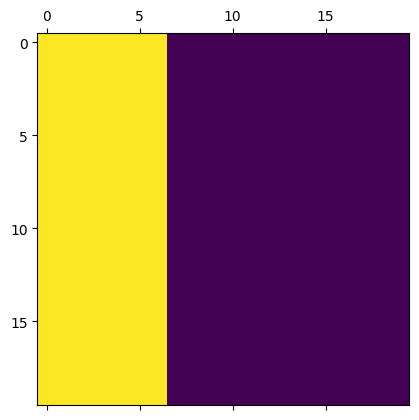

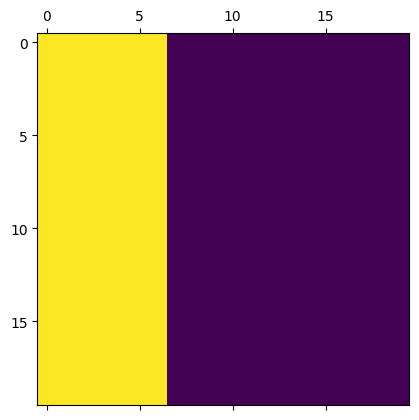

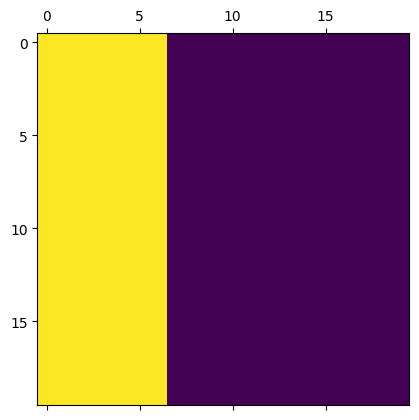

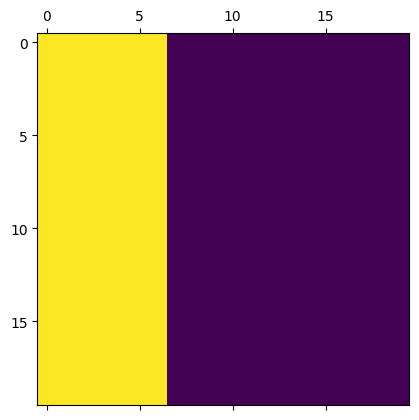

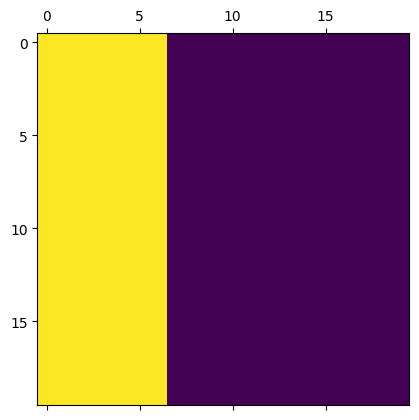

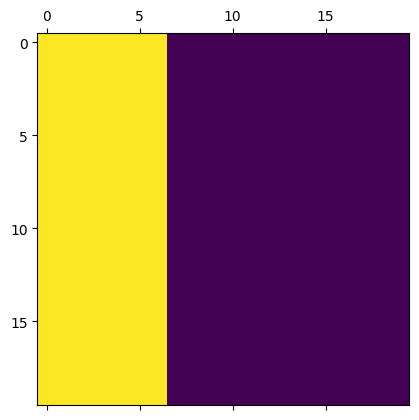

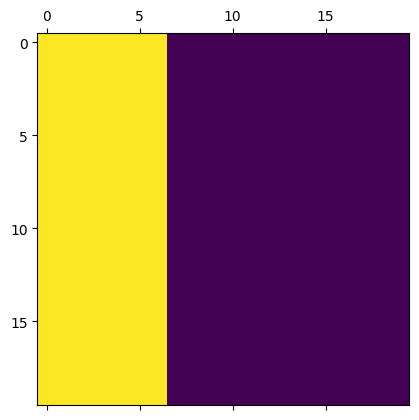

Translated Sentence:  <start> <end> 


In [ ]:
text="I think you should see this too"
evaluate([text],plot=True)